In [ ]:
# conda env list

# conda create -n [이름] python[버전]  -> 버전 안쓰면 최신버전을
# conda activate [이름]

# conda deactivate
# conda remove -n[이름] --all

<절차>
1. 입력
2. 토큰화 및 시퀀스 변화
3. 패딩(길이 고정)
4. 임베딩 (단어 벡터화)
5. 1D Convolution + poling 반복
6. Flatten
7. Dense(은닉)
8. 출력(소프트맥스, 이진분류)
9. 학습(Adam, Binary_Crossentropy)
10. 검증/ 테스트 평가
11. 시각화

---

- 말뭉치 로딩 (nltk) : 데이터 로딩
- 토큰화(빈도 기반 인덱싱) : 텍스트를 숫자로 변환
- 시퀀스 패딩 : 고정길이 배치
- 임베딩 : 단어를 밀집기준 벡터화  
    - 임베딩
        - 한계 : 작은 데이터에서는 일반화 부족
        - 발전 : 사전학습(Word2vec), 문맥적 임베딩(BERT, GPT)

<span style="color: Gold"> 말뭉치 로딩 (nltk) : 데이터 로딩

<span style="color: Gold"> 1. 토큰화(빈도 기반 인덱싱) : 텍스트를 숫자로 변환

In [94]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# sample data
texts = [
    "I really love this movie",
    'I hate this boring film',
    'love love great film'
]

# 토큰화 객체 (최대 단어 10, oov 토큰 지정)
tokenizer = Tokenizer(num_words=10, oov_token = 'UNK') # 최대 사용 단어 num_words=10 가장 많이 나오는 것중에 10개만 보겟다/ oov_token 내가 학습할 때 본 적 없는 단어. 즉 사전에 없는 단어
tokenizer.fit_on_texts(texts)
print(f'단어인덱스 : {tokenizer.word_index}')       # 토큰화된 단어를 보는 것


단어인덱스 : {'UNK': 1, 'love': 2, 'i': 3, 'this': 4, 'film': 5, 'really': 6, 'movie': 7, 'hate': 8, 'boring': 9, 'great': 10}


<span style="color: Gold"> 2. 시퀀스 패딩 : 고정길이 배치

In [95]:
# 시퀀스
seqs = tokenizer.texts_to_sequences(texts) # 위에 문장을 숫자로 바꾸는 것
print(f'원본 시퀀스 : {seqs}')
# 패딩(최대 길이를 6)
padded = pad_sequences(seqs, maxlen=6,padding='post')       # padding='post' 뒤에 패딩 넣기/ 앞이면 'pre'
print(f'패딩결과 : {padded}  사이즈 : {padded.shape}')

원본 시퀀스 : [[3, 6, 2, 4, 7], [3, 8, 4, 9, 5], [2, 2, 1, 5]]
패딩결과 : [[3 6 2 4 7 0]
 [3 8 4 9 5 0]
 [2 2 1 5 0 0]]  사이즈 : (3, 6)


<span style="color: Gold"> 3. 임베딩 : 단어를 밀집기준 벡터화

In [106]:
import tensorflow as tf
# 패딩된 시퀀스 padded
vocab_size = 11 # UNK를 포함하여 단어 인덱스 최대값 +1 -> num_words=10 +1을 해준다
embed_dim = 4  # 임베딩 차원. 벡터가 4차원
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embed_dim, input_length=6)    
]) # input_dim-> 입력 가능한 단어 인덱스 최대값+1 / output_dim -> 각 단어가 바뀔 벡터 차원 수/  input_length  -> 입력 시퀀스(문장)의 길이를 지정

embeddings = model.predict(padded)
print(f'임베딩 텐서 모양 : {embeddings.shape}')  #(3,6,4)
print(f'첫 문장 첫 단어 벡터 : {embeddings[0,0,:]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
임베딩 텐서 모양 : (3, 6, 4)
첫 문장 첫 단어 벡터 : [ 0.01441929  0.04681763  0.00701923 -0.04325027]


<span style="color: Gold"> 4. 1D Convolution

In [ ]:
import numpy as np
import tensorflow as tf
# 임의의 시퀀스 (배치 =1, 길이=6, 임베딩=4) → 1개의 문장, 6단어, 각 단어 4차원 벡터
x = np.random.randn(1,6,4).astype('float32')
conv = tf.keras.layers.Conv1D(
    filters = 2, # 2개의 패턴을 감지-> 긍정 부정을 감지
    kernel_size = 3, # 3-gram-> 3단어씩 묶어서(3-gram) 특징 추출
    activation = 'relu' # 음수값은 0으로, 양수만 통과
)
y = conv(x)
print(f'입력 shape {x.shape}')
print(f'출력 shape {y.shape}') # 4인 이유 -> 123,234,345,456
print(f'출력값 {y.numpy()}')

입력 shape (1, 6, 4)
출력 shape (1, 4, 2)
출력값 [[[0.         1.5551264 ]
  [1.1359663  0.96499085]
  [1.825316   0.        ]
  [0.         0.        ]]]


<span style="color: Gold"> 5. MaxPooling

In [22]:
pool = tf.keras.layers.MaxPool1D(pool_size =2)
pooled = pool(y)
print(f'폴링 전 : {y.shape}')
print(f'폴링 후 : {pooled.shape}')


폴링 전 : (1, 4, 2)
폴링 후 : (1, 2, 2)


---

<span style="color: pink"> 종합

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

texts = [
    "I really love this movie", # 긍정
    'I hate this boring film',  # 부정
    'great love movie',         # 긍정
    'boring hate film'          # 부정
]
labels = np.array([0,1,0,1])    # 긍정,부정,긍정,부정 라벨링

# 토큰화
tokenizer = Tokenizer(num_words=50,oov_token = 'UNK') 
tokenizer.fit_on_texts(texts)                       # 단어 사전 생성
seqs = tokenizer.texts_to_sequences(texts)          # 단어 사전 기반으로 단어들을 숫자로 변경

# 패딩 (최대 길이를 6)
x = pad_sequences(seqs, maxlen=6, padding='post')       # padding='post' 뒤에 패딩 넣기

# 임베딩
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim = 51, output_dim = 8, input_length = 6),
    tf.keras.layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')   # 마지막 출력층은 0,1 긍정부정으로 설정을 했으니까 2개로 해서 비율이 더 높은 걸로 보던가 아니면 하나만 출력하는 방식으로 선택 가능
                            # 두개를 주면 소프트 맥스
                            # 시그모이드로 할 경우에 하나로 설정, 그리고 임계치를 설정해줘야함. 보통 0.5. 절반으로 설정
])
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x, labels, epochs =15)

In [30]:
print(f"최종훈련 정확도 : {history.history['acc'][-1]}")
preds = model.predict(x)
print(preds)
print(f'라벨: {labels}')

최종훈련 정확도 : 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
[[0.47564846]
 [0.5005911 ]
 [0.4787427 ]
 [0.5030113 ]]
라벨: [0 1 0 1]


<span style="color: lightblue"> 시그모이드 vs 소프트 맥스를 언제 사용할까? </span>

<span style="font-size:11px;">

| 출력층 노드 수 | 활성화 함수 | 의미 | 동작 원리 | 클래스 결정 방식 | 사용 예시 |
|---------------|------------|------|------------|----------------|-----------|
| 1             | Sigmoid    | 0~1 범위 확률, 단일 출력으로 임계치 기준 판단 | 출력값 = 0~1 사이 실수<br>0.5 기준으로 판단<br>0.5 이상 → 클래스 1 (긍정)<br>0.5 미만 → 클래스 0 (부정) | 임계치(threshold, 보통 0.5) 기준 | 이진 분류 (Positive/Negative) |
| 2             | Softmax    | 각 클래스 확률, 출력값의 합 = 1 | 모든 출력의 합 = 1<br>각 값 = 해당 클래스 확률<br>예: [0.8, 0.2] → 긍정 80%, 부정 20% | argmax → 확률이 높은 클래스 선택 | 이진/다중 클래스 분류 |

---

예시 데이터로 실습

In [31]:
# nltk 데이터로드
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\SAMSUNG\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [66]:
# 재현성 시드 고정
import random
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [67]:
# 데이터 로딩
ids = movie_reviews.fileids()
reviews = [movie_reviews.raw(id) for id in ids]
categories = [movie_reviews.categories(id)[0] for id in ids]

In [68]:
# 하이퍼파라메터
    # 최대단어수
max_words = 10000
    # 문서길이
maxlen = 500
    # 임베딩차원
embed_dim = 64
    # batch_size
batch_size = 256
    # epoch
epochs = 15

# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=max_words,oov_token='UNK') 
tokenizer.fit_on_texts(reviews)                       # 단어 사전 생성
x = tokenizer.texts_to_sequences(reviews)          # 단어 사전 기반으로 단어들을 숫자로 변경
# 패딩
x = pad_sequences(x, maxlen=maxlen, truncating = 'post')       # 길이가 짧으면 padding, 길이가 길면 truncating을 사용한다
# padding -> 짧은 시퀀스 뒤나 앞에 **특정 값(보통 0)**을 채워서 길이를 맞춤
# truncating -> 긴 시퀀스를 잘라서(maxlen으로) 길이를 맞춤
# 라벨 인코딩
label_map = {'pos':0, 'neg':1}
y = np.array([label_map.get(c) for c in categories])

# train/test 분할
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y, random_state=42, test_size = 0.2)

# 모델구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words+1,output_dim=embed_dim,input_length=maxlen),
    tf.keras.layers.Conv1D(128,3,activation='relu'),
    tf.keras.layers.MaxPool1D(),  # 시퀀스의 구간별 특징 요약
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    # tf.keras.layers.GlobalAvgPool1D()  # 전체시퀀스의 평균  시퀀스차원없애고 채널 축만남김(채널에대한평균)
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])

# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
model.fit(
    x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

Epoch 1/15


c:\Users\SAMSUNG\anaconda3\envs\deep\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 799ms/step - acc: 0.5336 - loss: 0.6982 - val_acc: 0.5437 - val_loss: 0.6901
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 740ms/step - acc: 0.4891 - loss: 0.6949 - val_acc: 0.5437 - val_loss: 0.6925
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 717ms/step - acc: 0.5195 - loss: 0.6923 - val_acc: 0.5188 - val_loss: 0.6926
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 715ms/step - acc: 0.5414 - loss: 0.6909 - val_acc: 0.5562 - val_loss: 0.6903
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 821ms/step - acc: 0.6195 - loss: 0.6893 - val_acc: 0.5219 - val_loss: 0.6900
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 910ms/step - acc: 0.5391 - loss: 0.6868 - val_acc: 0.5188 - val_loss: 0.6918
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - acc: 0.5508 - loss: 0.6811 - val_acc: 0.5250 - val_loss: 0.6906
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - acc: 0.5875 - loss: 0.6714 - val_acc: 0.5281 - val_loss: 0.6891
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - acc: 0.6609 - loss: 0.6486 - val_acc: 0.

<span style="color: lightblue"> 모델구성 부분 설명

<span style="font-size:12px;">

| 레이어 | 역할 | 시각적 이해 |
|--------|------|------------|
| Embedding | 단어 → 벡터 | 각 단어를 “숫자 → 의미 벡터”로 변환. 예: `[1,2,3] → [[0.1,0.2],[0.5,0.1],[0.3,0.7]]` |
| Conv1D(128,3) | n-gram 특징 감지 | 3단어씩 묶어 슬라이딩하며 중요한 패턴 감지. 필터가 128개 → 128가지 특징을 동시에 학습 |
| MaxPool1D | 구간별 요약 | 슬라이딩된 출력에서 **가장 중요한 값만 추출**. 시퀀스 길이 감소 |
| Conv1D(256,3) | 더 복잡한 패턴 감지 | 이전 MaxPool 출력을 다시 스캔, 256개 특징 학습 |
| GlobalAvgPool1D | 시퀀스 요약 | 시퀀스 길이 전체 평균 → 고정 크기 벡터 (256차원) |

In [69]:
#conv1d   배치크기, 시퀀스길이, 채널수
x = tf.random.normal((32,10,64))
print(tf.keras.layers.Flatten()(x).shape)  
tf.keras.layers.GlobalAvgPool1D()(x).shape  # 각 채널 Feature map 마다 평균

(32, 640)


TensorShape([32, 64])

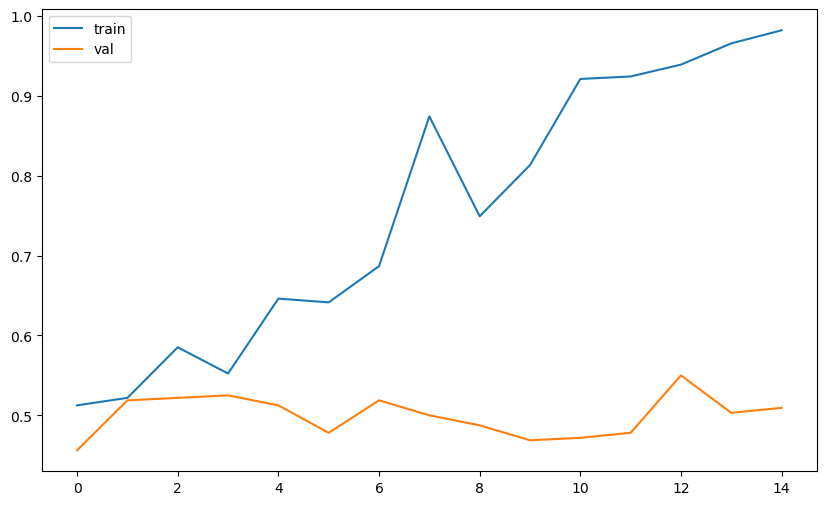

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - acc: 0.6525 - loss: 0.8174
test loss : 0.8174322247505188  test acc : 0.6524999737739563


In [73]:
# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')



In [74]:
# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]

x_sample = tokenizer.texts_to_sequences(sample_texts) 
x_sample = pad_sequences(x_sample, maxlen=maxlen, truncating = 'post')       
x_sample_predict = model.predict(x_sample)

x_sample_predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


array([[0.97091293],
       [0.9801576 ]], dtype=float32)

---

<span style="color: pink"> 개선 아이디어

학습된 모델을 추론해서 결과 보기

개선 아이디어
    GlobalMaxPooling 사용(Flatten 대신) → 파라미터 감소  
    다중 커널 크기(3,5,7) 병렬 적용 (TextCNN 구조)  
    Pretrained Embeddings (GloVe) 로 초기화
    과적합 방지: Dropout, L2 Regularization
    학습률 스케줄링(Cosine annealing, ReduceLROnPlateau)

<span style="color: #8A2BE2;"> 개선 1
- GlobalMaxPooling 사용(Flatten 대신) → 파라미터 감소
    - Flatten 대신 GlobalMaxPooling1D 각 필터의 최대값만 추출해서 파라메터수를 감소
    - 토크나이저 - 시퀀스-패딩---> X 라벨링 ---> y
    - 분할
    - 모델..Flatten GlobalMaxPool1D

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\SAMSUNG\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Epoch 1/15


c:\Users\SAMSUNG\anaconda3\envs\deep\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 811ms/step - acc: 0.5039 - loss: 0.6969 - val_acc: 0.4563 - val_loss: 0.6984
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 696ms/step - acc: 0.5555 - loss: 0.6850 - val_acc: 0.5625 - val_loss: 0.6926
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 704ms/step - acc: 0.7500 - loss: 0.6797 - val_acc: 0.4563 - val_loss: 0.6949
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step - acc: 0.5641 - loss: 0.6714 - val_acc: 0.4563 - val_loss: 0.6954
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 713ms/step - acc: 0.7328 - loss: 0.6603 - val_acc: 0.4594 - val_loss: 0.6932
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step - acc: 0.9461 - loss: 0.6467 - val_acc: 0.4563 - val_loss: 0.6931
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 712ms/step - acc: 1.0000 - loss: 0.6271 - val_acc: 0.6406 - val_loss: 0.6898
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step - acc: 1.0000 - loss: 0.6022 - val_acc: 0.6281 - val_loss: 0.6883
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step - acc: 1.0000 - loss: 0.5680 - va

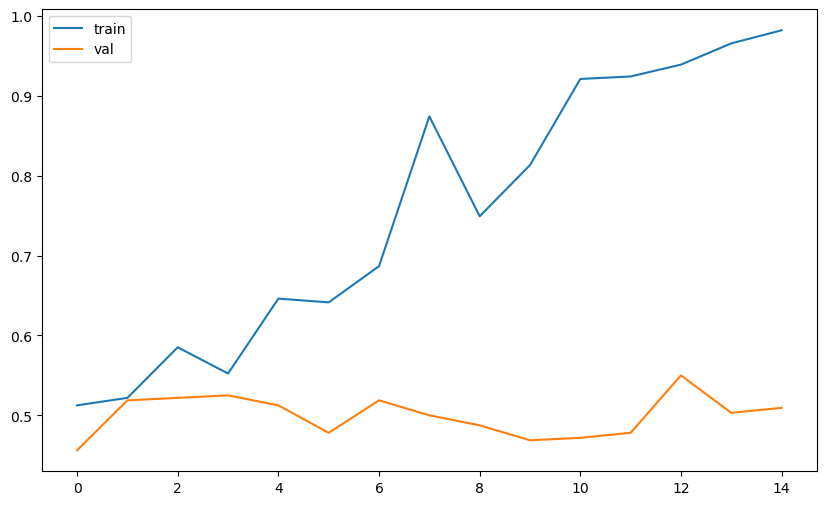

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.6675 - loss: 0.6243
test loss : 0.6243323683738708  test acc : 0.6675000190734863


In [ ]:
# nltk 데이터로드
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

# 재현성 시드 고정
import random
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# 데이터 로딩
ids = movie_reviews.fileids()
reviews = [movie_reviews.raw(id) for id in ids]
categories = [movie_reviews.categories(id)[0] for id in ids]

# 하이퍼파라메터
    # 최대단어수
max_words = 10000
    # 문서길이
maxlen = 500
    # 임베딩차원
embed_dim = 64
    # batch_size
batch_size = 256
    # epoch
epochs = 14


# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=max_words,oov_token='UNK') 
tokenizer.fit_on_texts(reviews)                       # 단어 사전 생성
x = tokenizer.texts_to_sequences(reviews)          # 단어 사전 기반으로 단어들을 숫자로 변경
# 패딩
x = pad_sequences(x, maxlen=maxlen, truncating = 'post')       # 길이가 짧으면 padding, 길이가 길면 truncating을 사용한다
# padding -> 짧은 시퀀스 뒤나 앞에 **특정 값(보통 0)**을 채워서 길이를 맞춤
# truncating -> 긴 시퀀스를 잘라서(maxlen으로) 길이를 맞춤
# 라벨 인코딩
label_map = {'pos':0, 'neg':1}
y = np.array([label_map.get(c) for c in categories])

# train/test 분할
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y, random_state=42, test_size = 0.2)

# 모델구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words+1,output_dim=embed_dim,input_length=maxlen),
    tf.keras.layers.Conv1D(128,3,activation='relu'),
    tf.keras.layers.MaxPool1D(),  # 시퀀스의 구간별 특징 요약
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),  # 전체시퀀스의 평균  시퀀스차원없애고 채널 축만남김(채널에대한평균)
    #tf.keras.layers.MaxPool1D(),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])

# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
model.fit(
    x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')



<span style="color: #8A2BE2;"> 개선2 
- 다중 커널 크기 병렬 적용(TextCNN)
    - 커널 크기 3 5 7 동시에 사용 다양한 tri-gram 5-gram 7-gram 포착

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 689ms/step - acc: 0.5109 - loss: 0.6952 - val_acc: 0.4563 - val_loss: 0.6997
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 682ms/step - acc: 0.5109 - loss: 0.6915 - val_acc: 0.4563 - val_loss: 0.6949
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - acc: 0.5109 - loss: 0.6910 - val_acc: 0.4563 - val_loss: 0.6940
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step - acc: 0.5109 - loss: 0.6905 - val_acc: 0.4563 - val_loss: 0.6950
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - acc: 0.5109 - loss: 0.6895 - val_acc: 0.4563 - val_loss: 0.6961
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - acc: 0.5109 - loss: 0.6882 - val_acc: 0.4563 - val_loss: 0.6964
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - acc: 0.5109 - loss: 0.6866 - val_acc: 0.4563 - val_loss: 0.6958
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - acc: 0.5109 - loss: 0.6844 - val_acc: 0.4563 - val_loss: 0.6948
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - acc: 0.5125 - loss: 

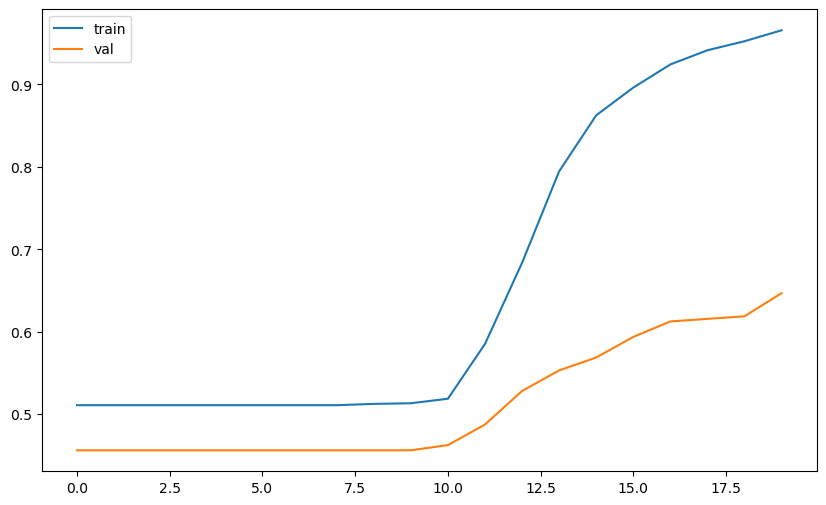

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.6525 - loss: 0.7026
test loss : 0.7025701403617859  test acc : 0.6524999737739563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


array([[0.78441983],
       [0.7913176 ]], dtype=float32)

In [117]:

from tensorflow.keras.layers import Input, Concatenate
# 입력레이어
input_layer = Input(shape=(maxlen ,) ,dtype='int32')
# 임베딩 레이어
embedding = tf.keras.layers.Embedding(max_words+1,embed_dim, input_length = maxlen )(input_layer)
conv_blocks = []
for kener_size in [3,5,7]:
    conv = tf.keras.layers.Conv1D(128,kener_size,activation='relu')(embedding)
    pool = tf.keras.layers.GlobalMaxPool1D()(conv)
    conv_blocks.append(pool)
# 병렬 브랜치 결합
concat = Concatenate()(conv_blocks)
# 완전연결층
dense = tf.keras.layers.Dense(64,activation='relu')(concat)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

#모델 생성
model = tf.keras.models.Model(inputs = input_layer, outputs = output)

# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=20,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

Pretrained Embedding(Glove)로 초기화


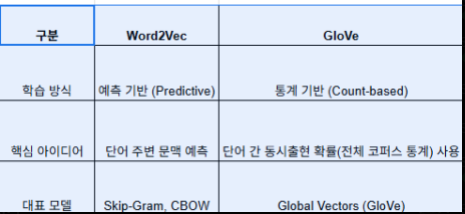

In [118]:
import gensim.downloader as api
import numpy as np
# Glove 모델(50차원)
wv = api.load('glove-wiki-gigaword-50')

In [119]:
# # 데이터셋에 사용된 단어
# “우리 데이터셋에서 사용되는 단어들”을
#  “GloVe가 이미 학습한 벡터”로 연결해서
# Embedding Laye 의 가중치 초기값으로 사용하기 위해 embedding_matrix를 만드는 것.
wv['king'].shape

(50,)

In [123]:
# nltk 데이터로드
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

# 재현성 시드 고정
import random
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


# 데이터 로딩
ids = movie_reviews.fileids()
reviews = [movie_reviews.raw(id) for id in ids]
categories = [movie_reviews.categories(id)[0] for id in ids]

# 하이퍼파라메터
    # 최대단어수
max_words = 10000
    # 문서길이
maxlen = 500
    # 임베딩차원
embed_dim = 50
    # batch_size
batch_size = 256
    # epoch
epochs = 15

# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=max_words,oov_token='UNK') 
tokenizer.fit_on_texts(reviews)                       # 단어 사전 생성
x = tokenizer.texts_to_sequences(reviews)          # 단어 사전 기반으로 단어들을 숫자로 변경
# 패딩
x = pad_sequences(x, maxlen=maxlen, truncating = 'post')       # 길이가 짧으면 padding, 길이가 길면 truncating을 사용한다
# padding -> 짧은 시퀀스 뒤나 앞에 **특정 값(보통 0)**을 채워서 길이를 맞춤
# truncating -> 긴 시퀀스를 잘라서(maxlen으로) 길이를 맞춤

# 라벨 인코딩
label_map = {'pos':0, 'neg':1}
y = np.array([label_map.get(c) for c in categories])

# train/test 분할
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y, random_state=42, test_size = 0.2)

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\SAMSUNG\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


매칭 : 9722 비매칭 : 277
커버리지 : 0.9722972297229723
Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 682ms/step - acc: 0.4984 - loss: 0.6946 - val_acc: 0.4563 - val_loss: 0.6964
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step - acc: 0.5109 - loss: 0.6907 - val_acc: 0.4563 - val_loss: 0.6952
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 734ms/step - acc: 0.5109 - loss: 0.6879 - val_acc: 0.4563 - val_loss: 0.6946
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step - acc: 0.5109 - loss: 0.6846 - val_acc: 0.4563 - val_loss: 0.6947
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step - acc: 0.5109 - loss: 0.6802 - val_acc: 0.4563 - val_loss: 0.6950
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 771ms/step - acc: 0.5188 - loss: 0.6742 - val_acc: 0.4563 - val_loss: 0.6946
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step - acc: 0.6828 - loss: 0.6661 - val_acc: 0.4563 - val_loss: 0.6938
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 869ms/step - acc: 0.9625 - loss: 0.6552 - val_acc: 0.4563 - val_loss: 0.6929
Epoch 9/15
5/5 ━━━━━━━━━━━

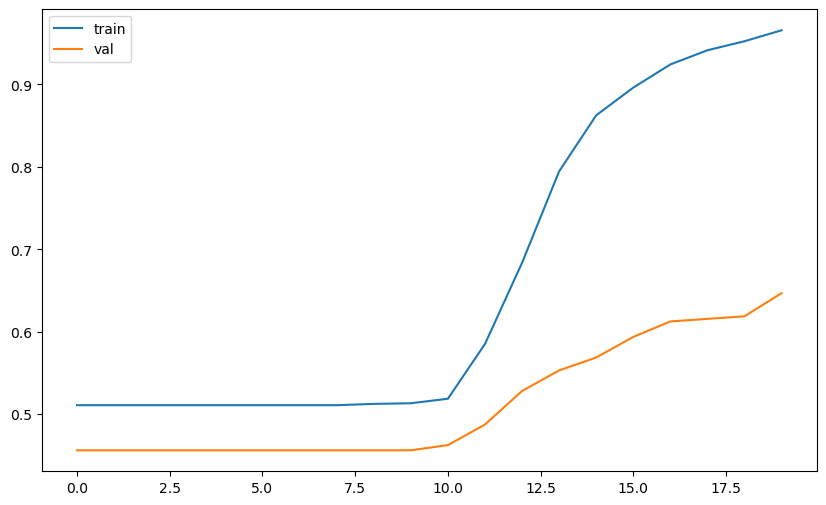

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.5075 - loss: 0.6690
test loss : 0.6690282225608826  test acc : 0.5074999928474426


In [128]:

# 임베딩 매트릭스 초기화
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) +1)
embedding_matrix = np.random.normal(
                loc = 0.0, scale = 0.1, size = (num_words,embed_dim))

# glove 매칭
hits = 0
misses = 0

for word, i in word_index.items():
    if i >= max_words:
        continue
    try:
        embedding_vector = wv[word]      # GloVe에서 단어 벡터 찾기
        embedding_matrix[i] = embedding_vector  # 해당 위치에 저장
        hits += 1
    except KeyError:
        misses += 1
print(f'매칭 : {hits} 비매칭 : {misses}')
print(f'커버리지 : {hits/(hits+misses)}')

tf.keras.models.Sequential([
    tf.keras.layers.Embedding(num_words, output_dim=embed_dim, input_length = maxlen,
                              weights=[embedding_matrix])
])

# 모델구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words+1,output_dim=embed_dim,input_length=maxlen),
    tf.keras.layers.Conv1D(128,3,activation='relu'),
    tf.keras.layers.MaxPool1D(),  # 시퀀스의 구간별 특징 요약
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),  # 전체시퀀스의 평균  시퀀스차원없애고 채널 축만남김(채널에대한평균)
    #tf.keras.layers.MaxPool1D(),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])

# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
model.fit(
    x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

다중커널 (3 5 7) + 드랍아웃 + L2 정규화

In [3]:
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras import regularizers 
# 입력레이어
input_layer = Input(shape=(maxlen ,) ,dtype='int32')
# 임베딩 레이어
embedding = tf.keras.layers.Embedding(max_words+1,embed_dim, input_length = maxlen )(input_layer)
conv_blocks = []
for kener_size in [3,5,7]:
    conv = tf.keras.layers.Conv1D(128,
                                  kener_size,
                                  activation='relu',
                                  kenel_regularizer = tf.keras.regularizers.l2(le-3))(embedding)
    pool = tf.keras.layers.GlobalMaxPool1D()(conv)
    conv_blocks.append(pool)
# 병렬 브랜치 결합
concat = Concatenate()(conv_blocks)
# 완전연결층
dense = tf.keras.layers.Dense(128,activation='relu',
                            kenel_regularizer = tf.keras.regularizers.l2(le-3))(concat)
dense = tf.keras.layers.Dropout(0.5)(dense)
dense = tf.keras.layers.Dense(64,activation='relu',
                            kenel_regularizer = tf.keras.regularizers.l2(le-3))(concat)
dense = tf.keras.layers.Dropout(0.3)(dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

#모델 생성
model = tf.keras.models.Model(inputs = input_layer, outputs = output)

# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=20,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

NameError: name 'maxlen' is not defined

---